In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.preprocessing as skp

## 1. Initial Exploration
### 1.1 Basics

In [26]:
df = pd.read_csv('archive/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

### 1.2 Exploratory Data Analysis
#### 1.2.1 Statistical Overview

In [28]:
# Descriptive Statistics
df[['price', 'number_of_reviews', 'reviews_per_month']].describe()

,price,number_of_reviews,reviews_per_month
count,48895.000000,48895.000000,38843.000000
mean,152.720687,23.274466,1.373221
std,240.154170,44.550582,1.680442
min,0.000000,0.000000,0.010000
25%,69.000000,1.000000,0.190000
50%,106.000000,5.000000,0.720000
75%,175.000000,24.000000,2.020000
max,10000.000000,629.000000,58.500000


During the initial exploration of the data, several important observations emerged. First, the minimum value of the price column is 0, which is highly unrealistic in the context of Airbnb listings and suggests the presence of outliers or incorrect data entries that will need to be addressed. Additionally, the maximum price value is significantly higher compared to the mean and median, indicating a highly skewed distribution and the likely presence of extreme outliers that could disproportionately influence the analysis. Regarding the reviews_per_month column, it is important to note that the descriptive statistics only account for non-null values. However, many null values may exist in this column, and these likely represent listings with zero reviews rather than missing or erroneous data. Therefore, appropriate preprocessing steps will be necessary to handle both outliers and missing values accurately before proceeding with more in-depth analysis and modeling.

In [29]:
# Checking for null values
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [30]:
#check the number of rows where last_review and reviews_per_month are both null
count = df[(df['last_review'].isnull()) & (df['reviews_per_month'].isnull())].shape[0]
print(count)

10052


As shown above there is a high number of null values for last_review and reviews_per_month column, and from the fact that the number of missing values for last_review and reviews_per_month are the same and that the number of rows with null values on both columns is also the same, we can infer that listings without a recorded last review also have no reviews per month, meaning the null values likely indicate listings with no reviews at all.

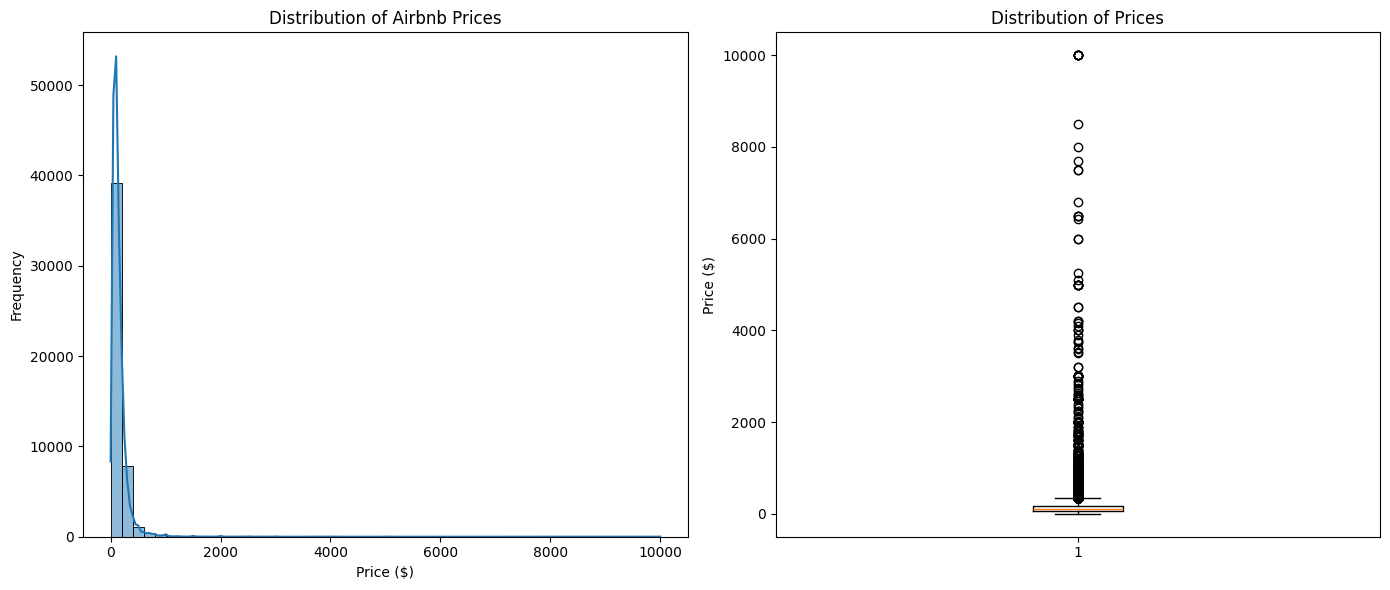

In [31]:
# Distribution of Prices
def show_distribution():

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figure size as needed
    
    # Histogram
    sns.histplot(df['price'], bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Distribution of Airbnb Prices')
    axes[0].set_xlabel('Price ($)')
    axes[0].set_ylabel('Frequency')
    
    # Boxplot
    axes[1].boxplot(df['price'])
    axes[1].set_title('Distribution of Prices')
    axes[1].set_ylabel('Price ($)')  # Optional, to match style
    
    plt.tight_layout()
    plt.show()

show_distribution()

As predicted from above, the distribution of prices is highly skewed and right-tailed, since there are a small number of listings with extremely high prices compared to the majority of listings clustered at lower price points. This heavy skewness suggests that a few very expensive properties are stretching the distribution toward the right, while most listings are priced at a more modest range. As a result, the mean price is pulled upward by these extreme values, making the median a potentially more reliable measure of central tendency for this dataset. Hence, this observation indicates the need for appropriate handling of outliers.

#### 1.2.2 Distribution of review data

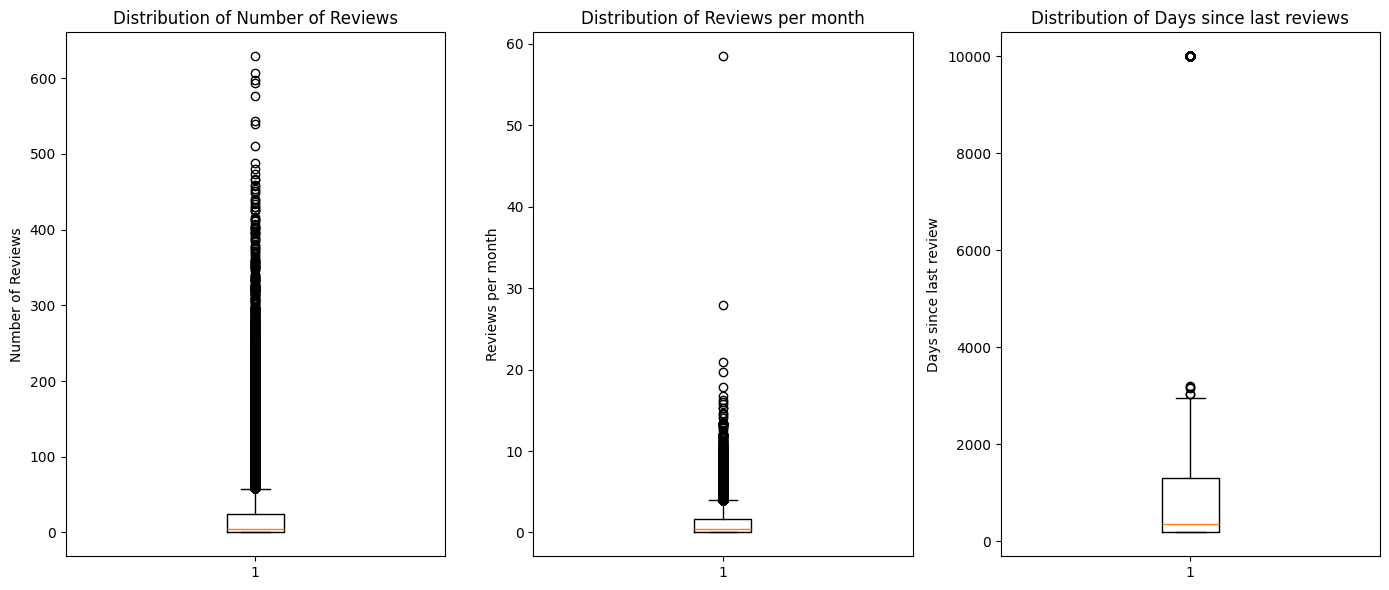

In [63]:
def show_distribution_reviews():

    fig, axes = plt.subplots(1, 3, figsize=(14, 6))  # Adjust figure size as needed

    # Boxplot_number_of_reveiws
    axes[0].boxplot(df['number_of_reviews'])
    axes[0].set_title('Distribution of Number of Reviews')
    axes[0].set_ylabel('Number of Reviews') 

    # Boxplot_reviews_per_month
    axes[1].boxplot(df['reviews_per_month'])
    axes[1].set_title('Distribution of Reviews per month')
    axes[1].set_ylabel('Reviews per month') 

    # Boxplot_days_since_last_review
    axes[2].boxplot(df['days_since_last_review'])
    axes[2].set_title('Distribution of Days since last reviews')
    axes[2].set_ylabel('Days since last review') 
    
    plt.tight_layout()
    plt.show()

show_distribution_reviews()

// explanation: lots of outliers

## 2. Data Preprocessing

In [32]:
# Handling missing values
# Fill missing reviews_per_month with 0, as no review means 0 per month
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [33]:
# Convert last_review to datetime
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

In [34]:
df['last_review'].dtype

dtype('<M8[ns]')

In [35]:
# Feature Engineering
# Create a new feature: days_since_last_review
df['days_since_last_review'] = (pd.Timestamp('2020-01-01') - df['last_review']).dt.days
## mention that the current date is set as the last day of 2019 since the dataset is from 2019

# Fill missing days_since_last_review with a large number (never reviewed)
df['days_since_last_review'] = df['days_since_last_review'].fillna(9999)

In the above code, I first handled the missing values in the reviews_per_month column by replacing them with 0, as the absence of values likely indicates that the listing had no reviews. To enable better operations and calculations involving dates, I then converted the last_review column into a proper datetime object. Following this, I created a new column called days_since_last_review, which represents the number of days between a reference date and the property's most recent review. Since the dataset is based on 2019 data, the "current date" used for this calculation was set to January 1, 2020, rather than today's actual date. Lastly, for listings that had missing values in the last_review column (meaning they had no reviews at all), I replaced the corresponding missing values in days_since_last_review with a very large number (9999). This was done to clearly distinguish properties with no review history from those with recent activity, ensuring that the model or subsequent analysis could appropriately account for listings that had never been reviewed.

In [36]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,439.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,225.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,0.00,1,365,9999.0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,180.0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,408.0


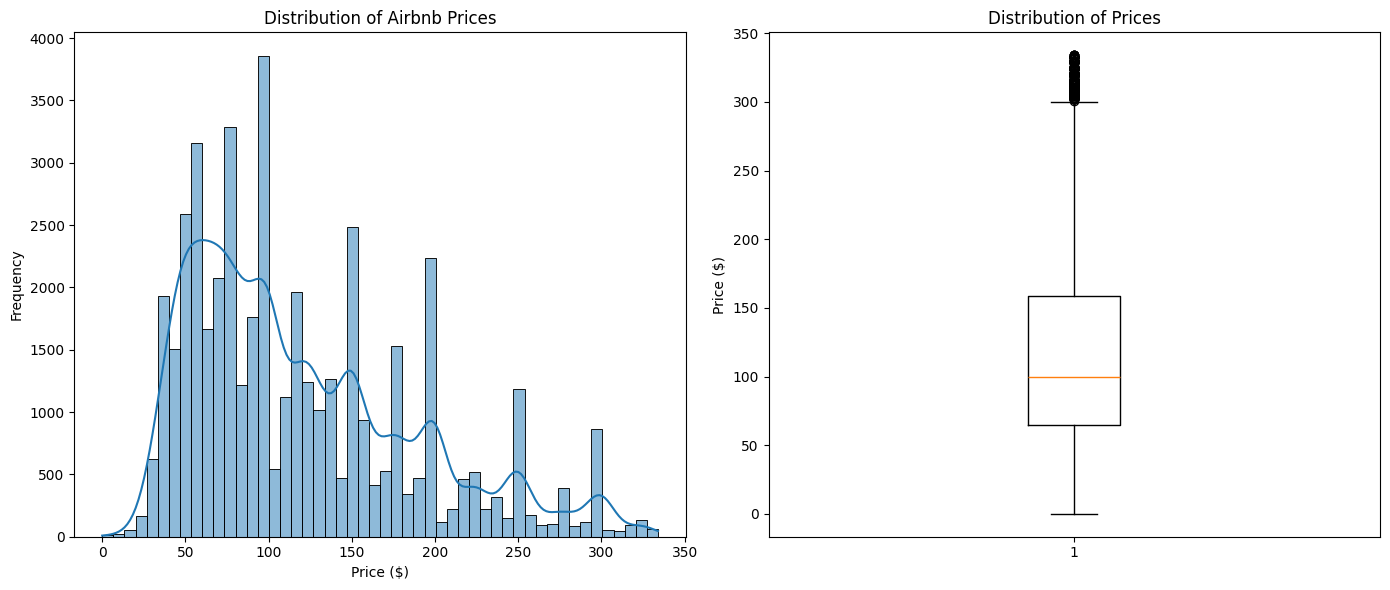

In [37]:
# Remove outliers in price
Q1 = df['price'].quantile(0.25)  # 25th percentile
Q3 = df['price'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1

# Define "outliers" as points outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]

show_distribution()

In [65]:
# Remove outliers in number_of_reviews
Q1_num_reviews = df['number_of_reviews'].quantile(0.25)  # 25th percentile
Q3_num_reviews = df['number_of_reviews'].quantile(0.75)  # 75th percentile
IQR_num_reviews = Q3 - Q1
df = df[(df['number_of_reviews'] >= Q1_num_reviews - 1.5 * IQR_num_reviews) & (df['number_of_reviews'] <= Q3_num_reviews + 1.5 * IQR_num_reviews)]

# Remove outliers in reviews_per_month
Q1_reviews_per_month = df['reviews_per_month'].quantile(0.25)  # 25th percentile
Q3_reviews_per_month = df['reviews_per_month'].quantile(0.75)  # 75th percentile
IQR_reviews_per_month = Q3 - Q1
df = df[(df['reviews_per_month'] >= Q1_reviews_per_month - 1.5 * IQR_reviews_per_month) & (df['reviews_per_month'] <= Q3_reviews_per_month + 1.5 * IQR_reviews_per_month)]

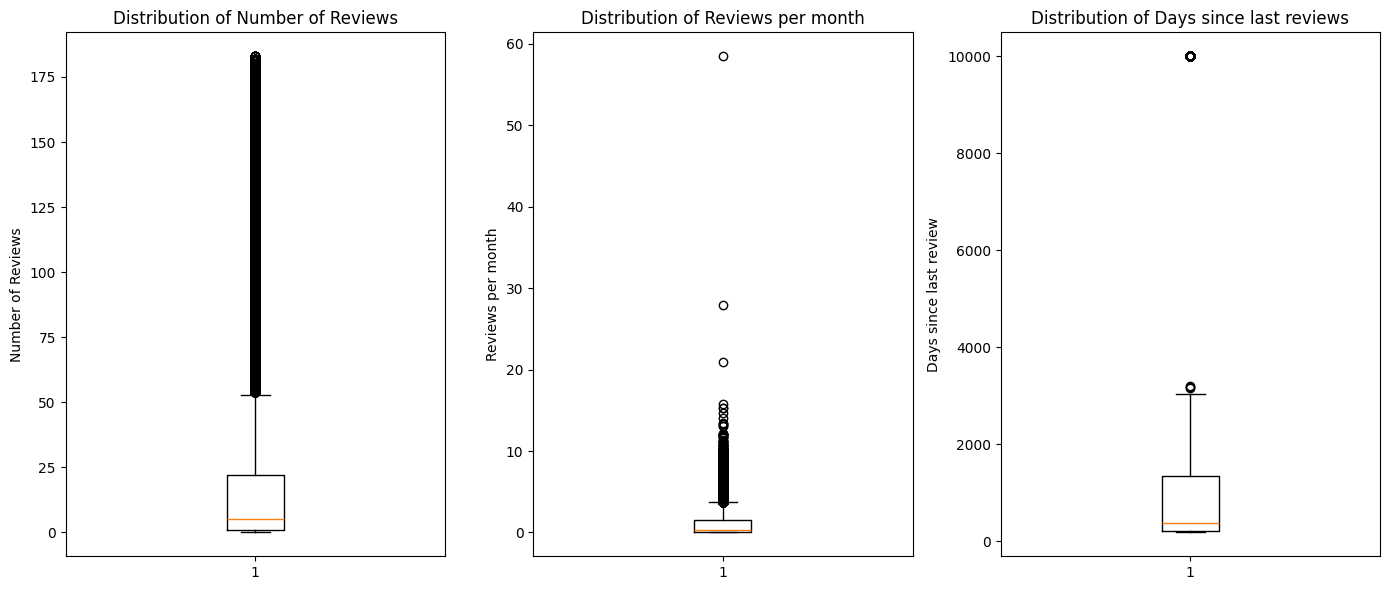

In [66]:
show_distribution_reviews()

In [38]:
# Normalize data (price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, days_since_last_review)
df['price_norm']=skp.MinMaxScaler().fit_transform(df['price'].values.reshape(-1,1))
df['minimum_nights_norm']=skp.MinMaxScaler().fit_transform(df['minimum_nights'].values.reshape(-1,1))
df['number_of_reviews_norm']=skp.MinMaxScaler().fit_transform(df['number_of_reviews'].values.reshape(-1,1))
df['reviews_per_month_norm']=skp.MinMaxScaler().fit_transform(df['reviews_per_month'].values.reshape(-1,1))
df['calculated_host_listings_count_norm']=skp.MinMaxScaler().fit_transform(df['calculated_host_listings_count'].values.reshape(-1,1))
df['days_since_last_review_norm']=skp.MinMaxScaler().fit_transform(df['days_since_last_review'].values.reshape(-1,1))

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review,price_norm,minimum_nights_norm,number_of_reviews_norm,reviews_per_month_norm,calculated_host_listings_count_norm,days_since_last_review_norm
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,0.21,6,365,439.0,0.446108,0.000000,0.014308,0.003590,0.015337,0.026675
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,0.38,2,355,225.0,0.673653,0.000000,0.071542,0.006496,0.003067,0.004887
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,0.00,1,365,9999.0,0.449102,0.001601,0.000000,0.000000,0.000000,1.000000
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,4.64,1,194,180.0,0.266467,0.000000,0.429253,0.079316,0.000000,0.000305
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,0.10,1,0,408.0,0.239521,0.007206,0.014308,0.001709,0.000000,0.023519


## 5. Statistical Tests

### 5.1 Correlation Matrix

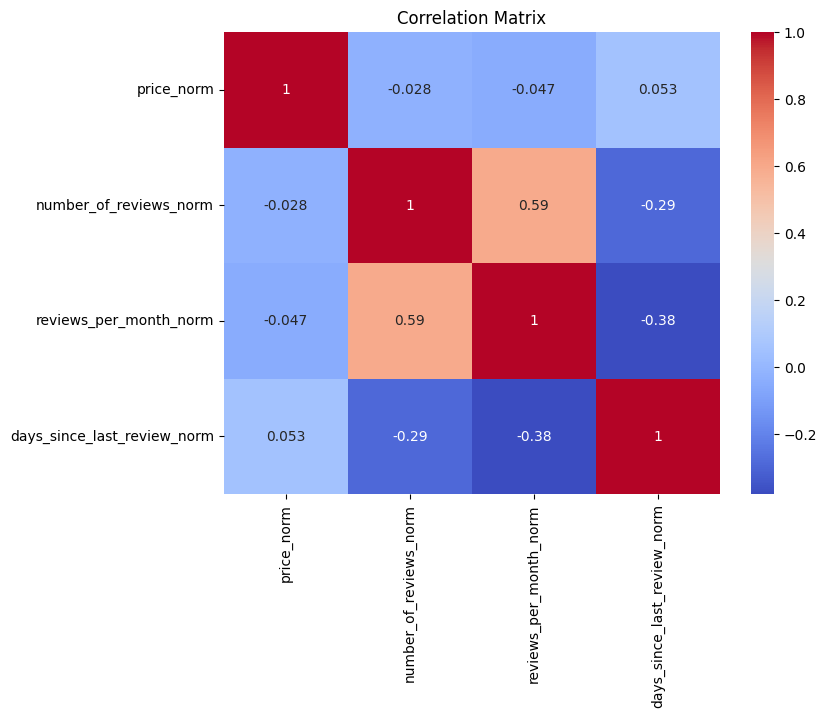

In [58]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['price_norm', 'number_of_reviews_norm', 'reviews_per_month_norm', 'days_since_last_review_norm' ]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### 5.2 Bin test

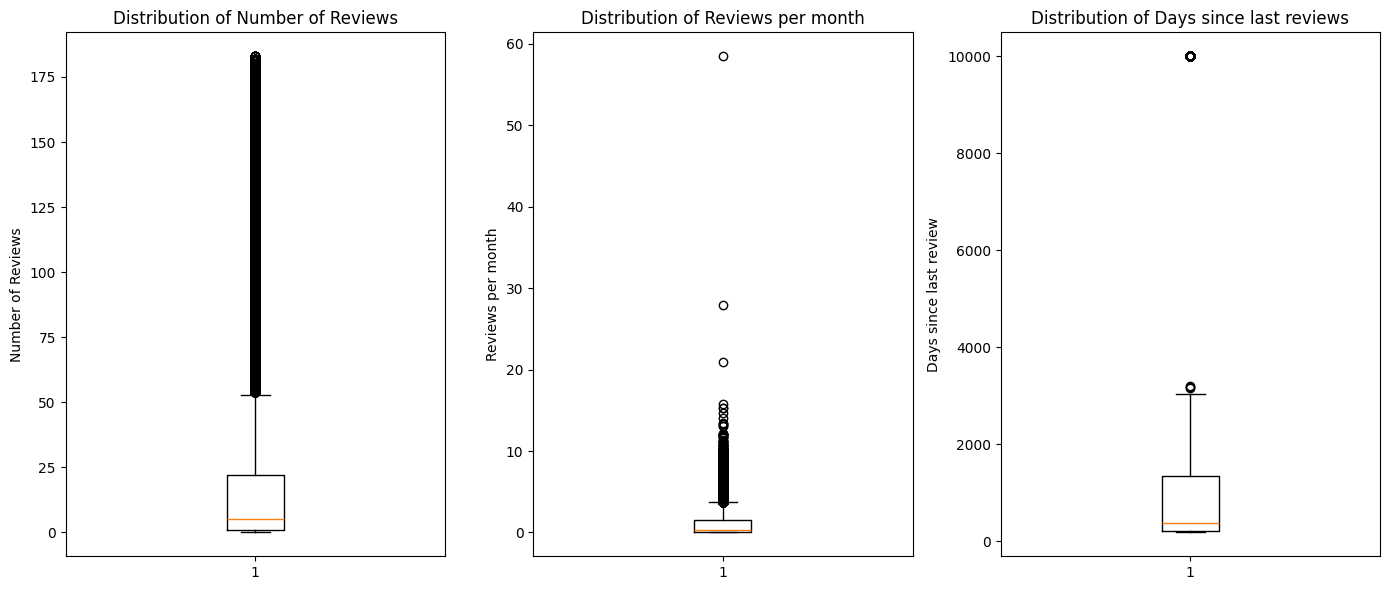

In [67]:
show_distribution_reviews()

Since the number of reviews, reviews per month, and days since the last review are continuous variables, a bined analysis was conducted to split the values into smaller groups and observe their relationship to price. Prior to conducting the test, it is essential to examine the distribution of each column to create appropriate bins. Therefore, the box plot generated earlier was carefully observed, and bins were created based on the distribution characteristics. Specifically, the box plot revealed key points such as the lower whisker, median, and upper whisker, which guided the creation of bins that capture meaningful segments of the data. For example, in case of number of reviews most of the data (Interquartile range) are distributed between 0-25, so more bins were allocated within this range to cover the high density fo values.

#### Number of reviews

/var/folders/vl/_bk7s0kx0kj68y31shfy7s_m0000gn/T/ipykernel_59966/61048068.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_num_reviews = df.groupby('number_of_reviews_bin')['price'].mean()


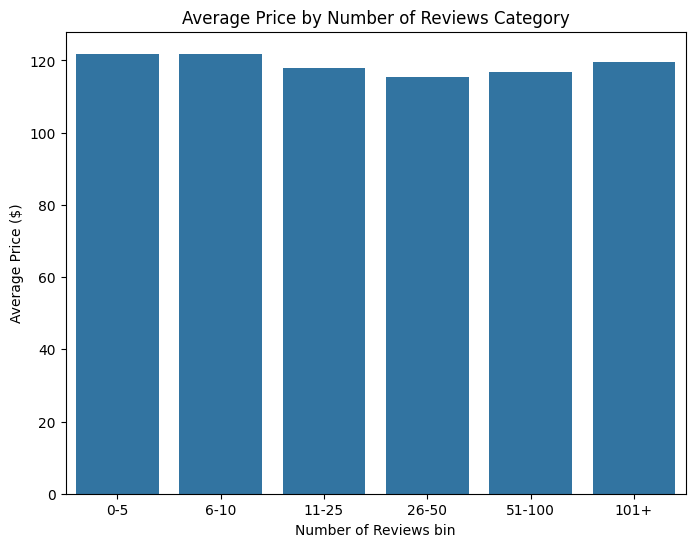

number_of_reviews_bin
0-5       121.872119
6-10      121.746205
11-25     118.039631
26-50     115.416101
51-100    116.771078
101+      119.474929
Name: price, dtype: float64

In [86]:
bins = [0, 5, 10, 25, 50, 100, 200]
labels = ['0-5', '6-10', '11-25', '26-50', '51-100', '101+']
df['number_of_reviews_bin'] = pd.cut(df['number_of_reviews'], bins=bins, labels=labels, include_lowest=True)

# Grouped Mean Price by Number of reviews bin
grouped_num_reviews = df.groupby('number_of_reviews_bin')['price'].mean()

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=grouped_num_reviews.index, y=grouped_num_reviews.values)
plt.title('Average Price by Number of Reviews Category')
plt.xlabel('Number of Reviews bin')
plt.ylabel('Average Price ($)')
plt.show()

grouped_num_reviews

The grouped number of reviews indicates a relatively stable relationship between the number of reviews and the price across the different bins, with only slight variations observed as the number of reviews increases. 

#### Reviews per Month

/var/folders/vl/_bk7s0kx0kj68y31shfy7s_m0000gn/T/ipykernel_59966/2625937868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_reviews_per_month = df.groupby('reviews_per_month_bin')['price'].mean()


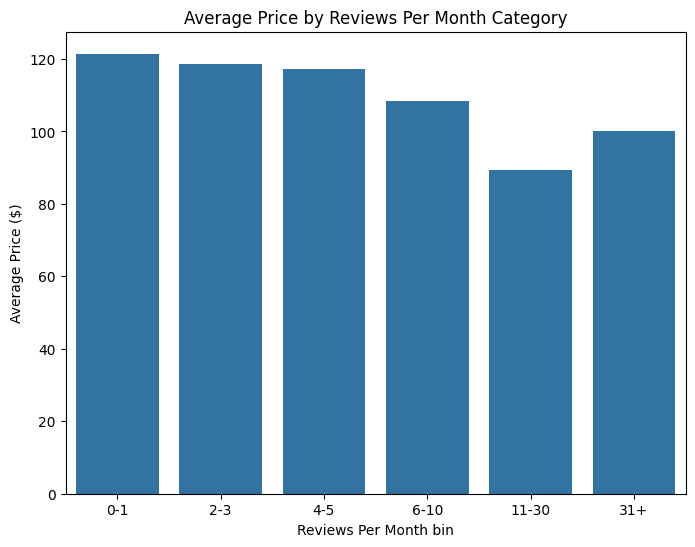

reviews_per_month_bin
0-1      121.444672
2-3      118.527543
4-5      117.120202
6-10     108.391833
11-30     89.478261
31+      100.000000
Name: price, dtype: float64

In [87]:
bins = [0, 1, 3, 5, 10, 30, 60]
labels = ['0-1', '2-3', '4-5', '6-10', '11-30', '31+']
df['reviews_per_month_bin'] = pd.cut(df['reviews_per_month'], bins=bins, labels=labels, include_lowest=True)

# Grouped Mean Price by reviews per month bin
grouped_reviews_per_month = df.groupby('reviews_per_month_bin')['price'].mean()

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=grouped_reviews_per_month.index, y=grouped_reviews_per_month.values)
plt.title('Average Price by Reviews Per Month Category')
plt.xlabel('Reviews Per Month bin')
plt.ylabel('Average Price ($)')
plt.show()

grouped_reviews_per_month

The reviews_per_month bins show a more noticeable downward trend in price as the review frequency increases. The "0-1" bin, representing properties with the fewest reviews per month, has a price of 121.44 dollars, which is the highest among the bins. This could be due to listings that either receive few reviews due to their newness or because they are priced higher but are not as frequently booked. As we move to the higher bins, such as "2-3" (118.53 dollars) and "4-5" (117.12 dollars), the prices gradually decrease, with the most significant drop occurring in the "6-10" bin, where prices fall to 108.39 dollars. Properties in this range may be experiencing more consistent bookings, but possibly at a lower price point. The lowest prices are observed in the "11-30" and "31+" bins, where prices are 89.48 and 100.00 dollars, respectively. This suggests that properties with a higher frequency of reviews (indicating frequent bookings) may be associated with lower prices, possibly due to discounts, promotions, or greater competition in the marketplace.

#### Days since last review

/var/folders/vl/_bk7s0kx0kj68y31shfy7s_m0000gn/T/ipykernel_59966/2179662625.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_days_since_last_review = df.groupby('days_since_last_review_bin')['price'].mean()


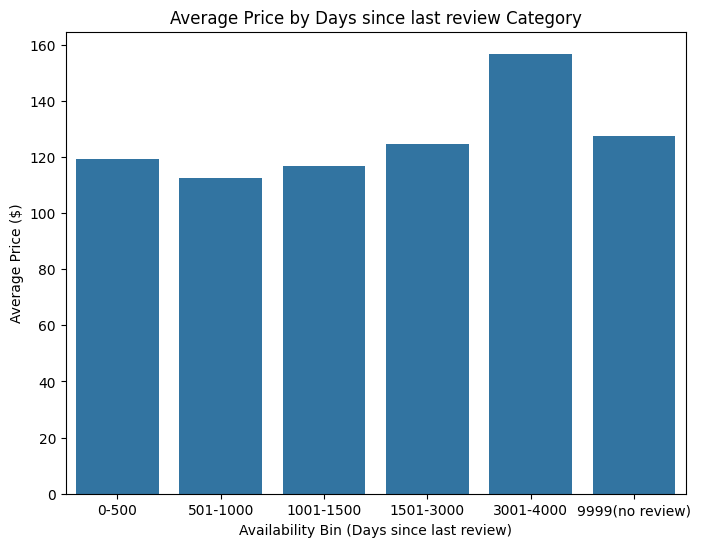

days_since_last_review_bin
0-500              119.311416
501-1000           112.562018
1001-1500          116.925315
1501-3000          124.462977
3001-4000          156.800000
9999(no review)    127.425211
Name: price, dtype: float64

In [70]:
bins = [0, 500, 1000, 1500, 3000, 4000, 10000]
labels = ['0-500', '501-1000', '1001-1500', '1501-3000', '3001-4000', '9999(no review)']
df['days_since_last_review_bin'] = pd.cut(df['days_since_last_review'], bins=bins, labels=labels, include_lowest=True)

# Grouped Mean Price by Number of reviews bin
grouped_days_since_last_review = df.groupby('days_since_last_review_bin')['price'].mean()

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=grouped_days_since_last_review.index, y=grouped_days_since_last_review.values)
plt.title('Average Price by Days since last review Category')
plt.xlabel('Days since last review bin')
plt.ylabel('Average Price ($)')
plt.show()

grouped_days_since_last_review

The days_since_last_review bins show a varied relationship with price, with the lowest prices observed for the most recent reviews (indicating higher turnover or more active listings). The "0-500" range, where listings have reviews that are relatively recent, has a price of 119.31 dollars, suggesting that these properties tend to have higher prices. This could be because recent reviews often reflect high demand and better-maintained listings. As the days since the last review increase, prices slightly decrease in the "501-1000" bin to 112.5 dollars, and then rise again to 116.93 dollars in the "1001-1500" bin, reflecting a somewhat complex relationship between price and review recency. The higher prices in this range could indicate listings that have been around for a while but still maintain high value. The "1501-3000" range sees a significant price increase to 124.46 dollars, which could suggest that listings with older reviews may either have undergone significant improvements or represent desirable locations that retain higher value over time. However, the "3001-4000" range, with prices as high as 156.80 dollars, represents the highest price group, which likely indicates that properties with reviews further in the past could still have great value due to location or unique features. The "9999 (no review)" bin shows a price of $127.43, indicating that properties with no reviews, often classified as new or untested listings, still have a relatively high price. This might reflect properties that have not yet been reviewed but are priced attractively to draw in initial customers.

## 6. Predictive Modeling

In [84]:
# Selecting features
features = ['number_of_reviews'] # ['number_of_reviews_norm','reviews_per_month_norm', 'days_since_last_review_norm']
X = df[features]
y = df['price']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print('Model Evaluation:')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'R2 Score: {r2_score(y_test, y_pred):.10f}')

Model Evaluation:
MAE: 55.46
R2 Score: 0.0002932074


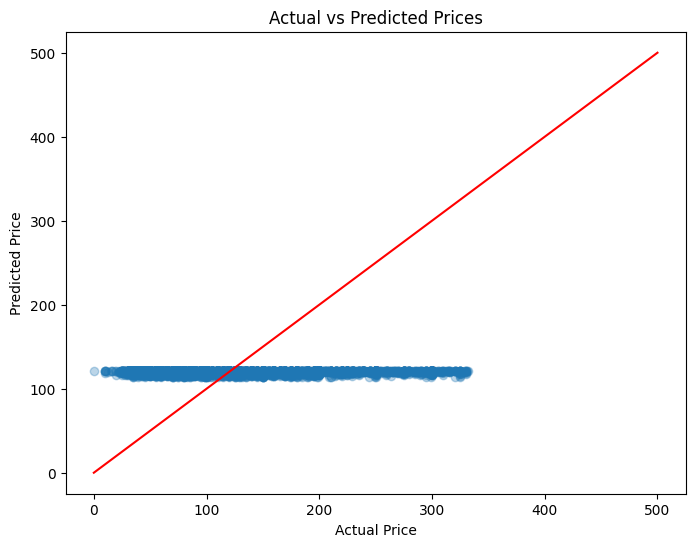

In [85]:
# Visualization of Prediction Performance
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0,500], [0,500], color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


## 7. Insights & Recommendations


///

## Extra Credit: Modelling (keyword analysis from property names)

In addition to analyzing numerical features, I conducted a keyword analysis on the property names to explore whether specific words are associated with variations in listing prices. Since property names often highlight key selling points or features — such as "luxury," "cozy," or "spacious" — understanding the language used could offer insights into how hosts market their properties and how that, in turn, relates to pricing strategies. This approach aims to capture qualitative signals from the dataset and examine their potential influence on price.

#### Methodology:
To perform the analysis, I first preprocessed the name column by tokenizing the text into individual words. I used CountVectorizer to transform the words into a numerical feature matrix, where each column represents a unique word and each row reflects the word counts for a listing. This allowed the text data to be represented in a machine-learning-friendly format. I then trained a Linear Regression model, using the word features as input and the listing prices as the target variable. By examining the learned model coefficients, I assessed the relationship between the presence of specific words and their corresponding influence on price — identifying which keywords tend to be associated with higher or lower pricing.

In [45]:
#Preprocess the 'name' column
df['name'] = df['name'].fillna('')  # Handle missing values
df['name'] = df['name'].str.lower()  # Lowercase

In [46]:
#Feature extraction: Convert names into word features
vectorizer = CountVectorizer(stop_words='english')  # Remove common stopwords automatically
X = vectorizer.fit_transform(df['name'])  # X is a sparse matrix

In [47]:
#Target variable
y = df['price']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train a model
model = LinearRegression()
model.fit(X_train, y_train)

#Predict
y_pred = model.predict(X_test)

In [48]:
#Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")

#Analyze word importance
#(The coefficients tell you which words are associated with higher/lower prices)
feature_names = vectorizer.get_feature_names_out()
coef_df = pd.DataFrame({'word': feature_names, 'coefficient': model.coef_})
coef_df = coef_df.sort_values('coefficient', ascending=False)

print(coef_df.head(10))  # Words most positively associated with price
print(coef_df.tail(10))  # Words most negatively associated with price

R² Score: 0.3275
Mean Absolute Error: 42.34
              word  coefficient
5789          seas   304.288580
712           5131   277.346028
2211  close2subway   240.420595
5413        quartz   240.402424
5498      redbrick   236.561632
1104      acogedor   232.442645
192            181   230.937362
5060      parkways   229.190926
6324     sunlights   226.079426
720           5143   224.878226
             word  coefficient
1251  apartamento  -153.470634
6087         spce  -156.576790
6161        start  -158.490441
4889       nyct02  -158.872539
4640       moment  -183.349661
3356   glittering  -187.840572
4698       mtrain  -217.331301
5431       quiete  -253.756364
5611       rincón  -270.935602
4272        lugar  -298.300039


#### Results and interpretation:

The linear regression model achieved an R² score of 0.3275, indicating that approximately 32.75% of the variance in property prices can be explained by the presence of specific words in the listing names. The model's mean absolute error (MAE) was 42.34, meaning that on average, the predicted prices deviated from the actual prices by about $42.34.

By examining the learned coefficients, we can identify which words are most strongly associated with price increases or decreases. Words such as "seas," "close2subway," "sunlights," and "redbrick" showed the highest positive coefficients, suggesting that listings containing these keywords tend to have higher prices. Seas, close2subway, sunlights are words that imply desirable locations and good quality, which makes sense in the context of higher prices. Generally, properties near the sea, with good sunlight, or in areas with good transportation links are priced higher.

Conversely, words like "lugar," "rincón," "quiete," "apartmento," and "glittering" had the most negative coefficients, indicating that their presence is associated with lower listing prices. Some of these negatively correlated terms may relate to smaller spaces, less convenient locations, or marketing language that does not translate into perceived value. For example, "apartamento" (which means apartment in Spanish) is often associated with smaller sizes and less privacy compared to standalone houses, making it likely to be correlated with lower prices. Additionally, there seems to be more Spanish words on the negative coefficient side, suggesting that language or the host's nationality could also be related to price. However, this connection is difficult to confirm solely based on the current results, and further research would be needed to investigate this potential correlation more thoroughly.

Overall, the analysis demonstrates that keywords embedded in property names carry meaningful signals about pricing, reinforcing the idea that language choices in marketing materials can influence customer perceptions and market positioning.

#### Limitation:

While the keyword analysis provides valuable insights, there are several limitations to consider. First, the relatively modest R² score suggests that while words contribute to price variance, a large portion of the variability is driven by other factors not captured by listing names alone — such as location, property size, amenities, and seasonal demand. Additionally, CountVectorizer treats words independently and does not capture context, nuance, or word combinations that may better explain pricing trends. Some words with strong coefficients might also appear infrequently, leading to unstable estimates. Finally, because the model assumes linear relationships, it may oversimplify more complex patterns between language and pricing. Future analysis could improve on these aspects by incorporating n-grams, using more sophisticated text representations (e.g., TF-IDF or embeddings), or combining text features with additional property metadata.